# 3D adv sin
PDE方程形式：
$$\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}+\frac{\partial u}{\partial z}+\frac{\partial u}{\partial t}=0$$
解的形式：
$$sin(x-t)+sin(y-t)+sin(z-t)$$
边界：
$$x\in[0,1]$$
$$y\in[0,1]$$
$$z\in[0,1]$$
$$t\in[0,2]$$
边界条件：无
初始条件：
$$u(x,y,z,0)=sin(x)+sin(y)+sin(z)$$

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




In [2]:
# Problem parameters:
x_min, y_min, z_min, t_min = 0,0,0,0
x_max, y_max, z_max, t_max = 1,1,1,2

lr = 1e-3
iterations = 20000
data_path_name = "./Advection/advection4_3d"
input_num = 4
net_node = 20
layers = 5

num_domain=2540 # 用于描述域内的点的数量
num_boundary=80 # 用于描述边界上的点的数量
num_initial=160 # 用于描述初始条件上的点的数量 160
num_test=2540 # 用于描述测试点的数量

In [3]:
def gen_testdata(path_name):
    """Import and preprocess the dataset with the exact solution."""
    data = np.load(path_name+".npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, y, z, exact = data["t"], data["x1"],data["x2"], data["x3"], data["usol"]
    # Process the data and flatten it out (like labels and features):
    xx, yy, zz, tt = np.meshgrid(x, y, z, t) # meshgrid：生成网格点坐标矩阵
    X = np.vstack((np.ravel(xx), np.ravel(yy),np.ravel(zz), np.ravel(tt))).T # ravel：将多维数组降为一维
    y = exact.flatten()[:, None]
    return X, y

# 定义PDE【需要修改】
def pde(x, y):
    """
        Expresses the PDE residual of the heat equation.
        在这里修改pde的内容, 从而获得解。让等式右侧为0
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=3) # y的0列对x的第2列进行求导
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_y = dde.grad.jacobian(y, x, i=0, j=1)
    dy_z = dde.grad.jacobian(y, x, i=0, j=2)
    return dy_t + dy_x + dy_y + dy_z

# Initial and boundary conditions: # 初始和边界条件【需要修改】
# 定义边界条件函数
def initial_condition(x):
    return np.sin(x[:,0:1]) +np.sin(x[:,1:2])+np.sin(x[:,2:3])


In [4]:
geom = dde.geometry.Cuboid([x_min, y_min, z_min], [x_max, y_max, z_max])
## 定义时间域. 和gen_exact_solution(char)中的t_min, t_max相同，如果和时间无关，可以注释掉
timedomain = dde.geometry.TimeDomain(t_min, t_max)
## GeometryXTime: 用于描述空间和时间的几何形状，如果和时间无关，则使用Geometry
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


ic = dde.icbc.IC(
    # IC: 用于描述初始条件
    geomtime,
    initial_condition,  # 初始条件的值为sin(n*pi*x/L)
    lambda _, on_initial: on_initial,  # on_initial: 初始条件的位置为初始位置
)

# 数据【需要修改】作为model的输入
data = dde.data.TimePDE(
    geomtime, # 用于描述空间和时间的几何形状
    pde, # 用于描述PDE的函数
    [ic], # 用于描述边界和初始条件的列表
    num_domain=num_domain, # 用于描述域内的点的数量
    num_boundary=num_boundary, # 用于描述边界上的点的数量
    num_initial=num_initial, # 用于描述初始条件上的点的数量 160
    num_test=num_test, # 用于描述测试点的数量
    # solution = func
)
# 定义网络，修改第1和最后一个参数，以及选择tanh或sigmoid作为激活函数
net = dde.nn.FNN([input_num] + [net_node] * layers + [1], "tanh", "Glorot normal")# 变量，神经元，隐藏层，输出，【需要修改】
    # Glorot normal: 一种初始化方法
model = dde.Model(data, net)


In [5]:
# 训练模型：先利用Adam进行训练，然后用L-BFGS进行训练
#快速降低损失
model.compile("adam", lr=lr) # 选择优化器和学习率【需要修改】
model.train(iterations=iterations) # 训练模型，迭代次数20000止
#精细调整
model.compile("L-BFGS") # 选择优化器
losshistory, train_state = model.train() # 训练模型


Compiling model...
Building feed-forward neural network...
'build' took 0.102754 s



/root/miniconda3/lib/python3.8/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-08-15 19:14:46.454041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 19:14:47.341527: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-15 19:14:47.341614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30279 MB memory:  -> device: 0, name: T

'compile' took 1.430329 s

Training model...



2023-08-15 19:14:47.790845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-08-15 19:14:47.899689: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f1244009930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 19:14:47.899741: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-08-15 19:14:47.908849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-15 19:14:49.091416: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [5.74e-02, 2.66e+00]    [5.47e-02, 2.66e+00]    []  
1000      [1.28e-04, 3.31e-04]    [6.15e-05, 3.31e-04]    []  
2000      [5.47e-05, 5.61e-05]    [2.16e-05, 5.61e-05]    []  
3000      [2.20e-05, 1.98e-05]    [9.57e-06, 1.98e-05]    []  
4000      [1.04e-05, 1.39e-05]    [4.98e-06, 1.39e-05]    []  
5000      [7.10e-06, 1.09e-05]    [3.44e-06, 1.09e-05]    []  
6000      [4.61e-06, 7.45e-06]    [2.14e-06, 7.45e-06]    []  
7000      [3.67e-06, 5.49e-06]    [1.60e-06, 5.49e-06]    []  
8000      [3.08e-06, 4.13e-06]    [1.28e-06, 4.13e-06]    []  
9000      [2.62e-06, 3.12e-06]    [1.05e-06, 3.12e-06]    []  
10000     [2.21e-06, 2.41e-06]    [8.51e-07, 2.41e-06]    []  
11000     [1.84e-06, 1.96e-06]    [6.83e-07, 1.96e-06]    []  
12000     [1.53e-06, 1.72e-06]    [5.52e-07, 1.72e-06]    []  
13000     [1.27e-06, 1.63e-06]    [4.44e-07, 1.63e-06]    []  
14000     [1.05e-06, 1.66e-06]    [3.54e-07, 1.6

2023-08-15 19:15:16.823637: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Step      Train loss              Test loss               Test metric
20000     [4.69e-07, 1.15e-06]    [1.41e-07, 1.15e-06]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000001
  Number of iterations: 144
  Number of functions evaluations: 163
20163     [3.21e-07, 7.67e-07]    [1.07e-07, 7.67e-07]    []  

Best model at step 20163:
  train loss: 1.09e-06
  test loss: 8.74e-07
  test metric: []

'train' took 2.338466 s



Saving loss history to /root/PINN/loss.dat ...
Saving training data to /root/PINN/train.dat ...
Saving test data to /root/PINN/test.dat ...


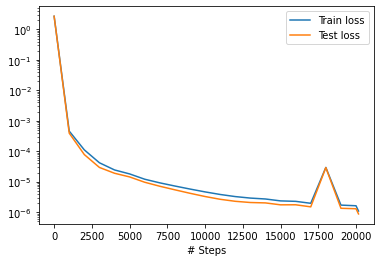

Mean Squared Error: 0.05499259184172199
Mean Squared Error Variance: 0.026725732908865957


In [6]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True) # 保存损失函数图像
X, y_true = gen_testdata(data_path_name) # 生成测试数据
y_pred = model.predict(X) # 预测

# 计算均方误差
mse = dde.metrics.mean_squared_error(y_true, y_pred)
print("Mean Squared Error:", mse)
# 计算均方误差的方差
mse_variance = np.var(y_true - y_pred)
print("Mean Squared Error Variance:", mse_variance)

In [7]:
data = np.load(data_path_name+".npz")
data.files

['x1', 'x2', 'x3', 't', 'usol']